In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import heapq
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score

In [2]:
data_25 = pd.DataFrame(pd.read_csv("data_df_25.csv"))
data_mean = pd.DataFrame(pd.read_csv("data_df_mean.csv"))
data_75 = pd.DataFrame(pd.read_csv("data_df_75.csv"))

data_X_25 = data_25[["SAT Critical Reading 25th percentile score", 
                         "SAT Math 25th percentile score",
                         "SAT Writing 25th percentile score", 
                         "ACT Composite 25th percentile score"]]
data_X_mean = data_mean[["SAT Critical Reading mean score", 
                         "SAT Math mean score",
                         "SAT Writing mean score", 
                         "ACT Composite mean score"]]
data_X_75 = data_75[["SAT Critical Reading 75th percentile score", 
               "SAT Math 75th percentile score",
               "SAT Writing 75th percentile score", 
               "ACT Composite 75th percentile score"]]

data_y = data_25["Name"].tolist()

In [3]:
data_25.describe()

,SAT Critical Reading 25th percentile score,SAT Math 25th percentile score,SAT Writing 25th percentile score,ACT Composite 25th percentile score
count,677.000000,677.000000,677.000000,677.000000
mean,481.016248,490.649926,472.193501,21.112260
std,75.384977,80.048377,80.773477,3.913538
min,310.000000,280.000000,310.000000,13.000000
25%,430.000000,430.000000,415.000000,18.000000
50%,470.000000,470.000000,455.000000,20.000000
75%,520.000000,530.000000,510.000000,23.000000
max,720.000000,770.000000,720.000000,33.000000


In [6]:
def normDF(data_X):
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 10))
    scaler.fit(data_X)
    X_norm = scaler.transform(data_X)
    data_norm_25 = pd.DataFrame(X_norm)
    return data_norm_25
"""
data_norm_25 = normDF(data_X_25)
data_norm_mean = normDF(data_X_mean)
data_norm_75 = normDF(data_X_75)
data_norm_75.describe()
"""

,0,1,2,3
count,677.000000,677.000000,677.000000,677.000000
mean,5.181583,4.809794,4.942225,5.710769
std,1.720260,1.994037,1.813980,1.763667
min,0.000000,0.000000,0.000000,0.000000
25%,3.931818,3.333333,3.636364,4.285714
50%,5.000000,4.615385,4.772727,5.238095
75%,6.136364,5.897436,5.909091,6.666667
max,10.000000,10.000000,10.000000,10.000000


In [7]:
#to transform features by scaling each feature to a given range, e.g. between zero and one.
def minmaxscaler_input(df,train_X):
    maxlist = df.max().to_list()
    minlist = df.min().to_list()
    input_scale = []
    for i in range(len(train_X)):
        input_scale.append((train_X[i] - minlist[i])/(maxlist[i] -minlist[i])*10)
    return input_scale

In [8]:
#to calculate the similarity between input score and all school's 

def similarity(compare_value, train_X,threshold=1):
    #a= np.array(compare_value)
    #b=np.array(input_value)
    cos_lib = 1-pairwise_distances(compare_value,train_X)/threshold
    cos_lib = relu1(cos_lib)
    return cos_lib

def relu1(result):
    return min(max(result[0][0],0),1)
#
def similarity_sort(data_X, data_y, train_X,threshold):
    #data is the (k,4) matrix, input_valueis a (1,4) array
    sim_score = []
    sim_name = []
    name = ""
    b = np.array([train_X])
    for i in range(np.shape(data_X)[0]): # for each college
        a= np.array([data_X.values[i]])

        cos_lib = similarity(a,b,threshold)
        
        name = data_y[i]
        sim_score.append(cos_lib)
        sim_name.append(name)
    sim_list = heapq.nlargest(3, zip(sim_score, sim_name))
    return sim_list #return similiarity score and name of top 3 schools

In [9]:
def sim_input(df,data_y,input_data,threshold):
    #max_min scale the input value to fit the dataset
    input_value = np.array(minmaxscaler_input(df,input_data))
    #max_min scale the chosen dataset
    df_norm = normDF(df)
    #calculate the similaity between input and all school's data,
    #sort and return top 3 match school
    sim = similarity_sort(df_norm,data_y,input_value,threshold)
    return sim

def prediction(data,input_data,threshold):
    data_X = data.drop(columns = ["Name"])
    data_y = data["Name"].tolist()
    sim_result_score = []
    sim_result_name = []
    for i in range(3):
        sim_result = sim_input(data_X,data_y,input_data,threshold)[i]
        sim_result_name.append(sim_result[1]) 
        recommend = np.array(data.loc[data["Name"] == sim_result_name[i]])[0]
        sim_result_score.append(recommend[1:].tolist())
    return sim_result_name,sim_result_score

In [11]:
# comapre different threshold impact to similarity funciton 
"""
from sklearn.metrics import jaccard_score
from sklearn.metrics import pairwise_distances
y_true = np.array([[3.64705882,3.21428571,3.20987654,4.14634146]])
y_pred = np.array([[4.23529412,3.80952381,3.7037037 ,4.87804878]])

input_data = [490.0,500.0,480.0,22.0]
train_data1 = [490.0,490.0,480.0,22.0]
train_data2 = [490.0,525.0,500.0,23.5]
train_data3 = [515.0,525.0,500.0,23.5]
train_data4 = [720.0,770.0,720.0,33.0]
amm = minmaxscaler_input(data_X_mean,input_data)
bmm1 = minmaxscaler_input(data_X_mean,train_data1)
bmm2 = minmaxscaler_input(data_X_mean,train_data2)
bmm3 = minmaxscaler_input(data_X_mean,train_data3)
bmm4 = minmaxscaler_input(data_X_mean,train_data4)
a = np.array([amm])
b1 = np.array([bmm1])
b2 = np.array([bmm2])
b3 = np.array([bmm3])
b4 = np.array([bmm4])
print(a)
print(b1)
print(b2)
print(b3)
print(b4)
print(similarity(a,b1,1))
print(similarity(a,b2,1))
print(similarity(a,b3,1))
print(similarity(a,b4,1))
print(similarity(a,b1,1.25))
print(similarity(a,b2,1.25))
print(similarity(a,b3,1.25))
print(similarity(a,b4,1.25))
print(similarity(a,b1,1.5))
print(similarity(a,b2,1.5))
print(similarity(a,b3,1.5))
print(similarity(a,b4,1.5))
"""

[[3.64705882 3.21428571 3.20987654 4.14634146]]
[[3.64705882 2.97619048 3.20987654 4.14634146]]
[[3.64705882 3.80952381 3.7037037  4.87804878]]
[[4.23529412 3.80952381 3.7037037  4.87804878]]
[[9.05882353 9.64285714 9.13580247 9.51219512]]
0.7619047619047442
0
0
0
0.8095238095237953
0.1482463258157367
0.026892807197670954
0
0.8412698412698295
0.2902052715131139
0.18907733933139248
0


In [13]:
from sklearn.metrics import mean_squared_error
def mse_df(df,a,b):
    a_nm = minmaxscaler_input(df,a)
    b_nm = minmaxscaler_input(df,b)

    pred_mse = mean_squared_error(a_nm,b_nm)
    return pred_mse
'''
input_data = [490.0,500.0,480.0,22.0]
train_data1 = [490.0,490.0,480.0,22.0]
print(mse_df(data_X_25,input_data,train_data1))
'''

0.010412328196584735


In [14]:
def evaluation(df,threshold):
    data_X = df.drop(columns = ["Name"])
    data_y = df["Name"].tolist()
    X_train, X_test, y_train, y_test = train_test_split(data_X, 
                                                        data_y, 
                                                        test_size=0.2,
                                                        random_state=42)
    mse_list = []
    for index, row  in X_test.iterrows(): 
        input_data = row.tolist()
        pred_name,pred_score = prediction(df,input_data,threshold)
        for i in range(len(pred_score)):
            pred = pred_score[i]
            pred_mse = mse_df(data_X,input_data,pred)
            mse_list.append(pred_mse)
    avg_mse = sum(mse_list) / len(mse_list)
    print(avg_mse)
    return avg_mse

def find_ideal_threshold(df):
    least_mse_score = 1
    ideal_threshold = 0
    for i in np.arange(1,3,0.02):
        curr_score =evaluation(df,i)
        if least_mse_score > curr_score:
            least_mse_score = curr_score
            ideal_threshold = i
    
    return least_mse_score,ideal_threshold

def save_threshold(df1,df2,df3):
    lms_25, ideal_threshold_25 =find_ideal_threshold(df1)
    lms_mean,ideal_threshold_mean =find_ideal_threshold(df2)
    lms_75, ideal_threshold_75 =find_ideal_threshold(df3)
    ideal = []
    ideal.append(round(ideal_threshold_25, 2))
    ideal.append(round(ideal_threshold_mean, 2))
    ideal.append(round(ideal_threshold_75, 2))
    with open('threshold.txt', 'w+') as f:
        for item in ideal:
            f.write("%s\n" % item)
    print("The least mse score to data_25 is:",lms_25)
    print("The least mse score to data_mean is:",lms_mean)
    print("The least mse score to data_75 is:",lms_75)
    

In [20]:
def prediction_school(input_data):
    data_25 = pd.DataFrame(pd.read_csv("data_df_25.csv"))
    data_mean = pd.DataFrame(pd.read_csv("data_df_mean.csv"))
    data_75 = pd.DataFrame(pd.read_csv("data_df_75.csv"))
    threshold = open('threshold.txt','r').readlines()
    threshold = [float(i) for i in threshold]
    pred1_name,pred1_score = prediction(data_25,input_data,threshold[0])
    pred2_name,pred2_score = prediction(data_mean,input_data,threshold[1])
    pred3_name,pred3_score = prediction(data_75,input_data,threshold[2])
    pred_name = pred1_name + pred2_name + pred3_name
    pred_score = pred1_score + pred2_score + pred3_score
    return pred_name,pred_score

In [15]:
#save_threshold(data_25,data_mean,data_75)

0.06865552965835404
0.04149384489436609
0.04149384489436609
0.04149384489436609
0.03293070937294537
0.03293070937294537
0.030563493926993292
0.030563493926993292
0.030563493926993292
0.030563493926993292
0.030563493926993292
0.030563493926993292
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.026557800418362084
0.02655780041836208

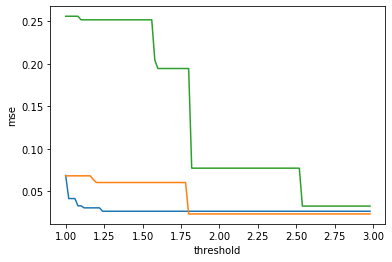

In [34]:
mse_25= [0.06865552965835404,0.04149384489436609,0.04149384489436609,0.04149384489436609,0.03293070937294537,
         0.03293070937294537,0.030563493926993292,0.030563493926993292,0.030563493926993292,0.030563493926993292,
         0.030563493926993292,0.030563493926993292,0.026557800418362084,0.026557800418362084,0.026557800418362084,
         0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,
         0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,
         0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,
         0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,
         0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,
         0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,
         0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,
         0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,
         0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,
         0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,
         0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,
         0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,
         0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,
         0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,
         0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,
         0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,
         0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,0.026557800418362084,
        ]
mse_mean = [0.06823537065942097,0.06823537065942097,0.06823537065942097,0.06823537065942097,0.06823537065942097,
            0.06823537065942097,0.06823537065942097,0.06823537065942097,0.06823537065942097,0.06383405272172399,
            0.060396721391178555,0.060396721391178555,0.060396721391178555,0.060396721391178555,0.060396721391178555,
            0.060396721391178555,0.060396721391178555,0.060396721391178555,0.060396721391178555,0.060396721391178555,
            0.060396721391178555,0.060396721391178555,0.060396721391178555,0.060396721391178555,0.060396721391178555,
            0.060396721391178555,0.060396721391178555,0.060396721391178555,0.060396721391178555,0.060396721391178555,
            0.060396721391178555,0.060396721391178555,0.060396721391178555,0.060396721391178555,0.060396721391178555,
            0.060396721391178555,0.060396721391178555,0.060396721391178555,0.060396721391178555,0.060396721391178555,
            0.02342176295254015,0.02342176295254015,0.02342176295254015,0.02342176295254015,0.02342176295254015,
            0.02342176295254015,0.02342176295254015,0.02342176295254015,0.02342176295254015,0.02342176295254015,
            0.02342176295254015,0.02342176295254015,0.02342176295254015,0.02342176295254015,0.02342176295254015,
            0.02342176295254015,0.02342176295254015,0.02342176295254015,0.02342176295254015,0.02342176295254015,
            0.02342176295254015,0.02342176295254015,0.02342176295254015,0.02342176295254015,0.02342176295254015,
            0.02342176295254015,0.02342176295254015,0.02342176295254015,0.02342176295254015,0.02342176295254015,
            0.02342176295254015,0.02342176295254015,0.02342176295254015,0.02342176295254015,0.02342176295254015,
            0.02342176295254015,0.02342176295254015,0.02342176295254015,0.02342176295254015,0.02342176295254015,
            0.02342176295254015,0.02342176295254015,0.02342176295254015,0.02342176295254015,0.02342176295254015,
            0.02342176295254015,0.02342176295254015,0.02342176295254015,0.02342176295254015,0.02342176295254015,
            0.02342176295254015,0.02342176295254015,0.02342176295254015,0.02342176295254015,0.02342176295254015,
            0.02342176295254015,0.02342176295254015,0.02342176295254015,0.02342176295254015,0.02342176295254015
           ]

mse_75 = [0.25603977651401755,0.25603977651401755,0.25603977651401755,0.25603977651401755,0.25603977651401755,
          0.25183767145011343,0.25183767145011343,0.25183767145011343,0.25183767145011343,0.25183767145011343,
          0.25183767145011343,0.25183767145011343,0.25183767145011343,0.25183767145011343,0.25183767145011343,
          0.25183767145011343,0.25183767145011343,0.25183767145011343,0.25183767145011343,0.25183767145011343,
          0.25183767145011343,0.25183767145011343,0.25183767145011343,0.25183767145011343,0.25183767145011343,
          0.25183767145011343,0.25183767145011343,0.25183767145011343,0.25183767145011343,0.20441327768042888,
          0.19452828989053347,0.19452828989053347,0.19452828989053347,0.19452828989053347,0.19452828989053347,
          0.19452828989053347,0.19452828989053347,0.19452828989053347,0.19452828989053347,0.19452828989053347,
          0.19452828989053347,0.07725632705834032,0.07725632705834032,0.07725632705834032,0.07725632705834032,
          0.07725632705834032,0.07725632705834032,0.07725632705834032,0.07725632705834032,0.07725632705834032,
          0.07725632705834032,0.07725632705834032,0.07725632705834032,0.07725632705834032,0.07725632705834032,
          0.07725632705834032,0.07725632705834032,0.07725632705834032,0.07725632705834032,0.07725632705834032,
          0.07725632705834032,0.07725632705834032,0.07725632705834032,0.07725632705834032,0.07725632705834032,
          0.07725632705834032,0.07725632705834032,0.07725632705834032,0.07725632705834032,0.07725632705834032,
          0.07725632705834032,0.07725632705834032,0.07725632705834032,0.07725632705834032,0.07725632705834032,
          0.07725632705834032,0.07725632705834032,0.032627104737324455,0.032627104737324455,0.032627104737324455,
          0.032627104737324455,0.032627104737324455,0.032627104737324455,0.032627104737324455,0.032627104737324455,
          0.032627104737324455,0.032627104737324455,0.032627104737324455,0.032627104737324455,0.032627104737324455,
          0.032627104737324455,0.032627104737324455,0.032627104737324455,0.032627104737324455,0.032627104737324455,
          0.032627104737324455,0.032627104737324455,0.032627104737324455,0.032627104737324455,0.032627104737324455
         ]

mse_x = np.arange(1,3,0.02)

import matplotlib.pyplot as plt

plt.xlabel('threshold')
plt.ylabel('mse')
plt.plot(np.array(mse_x),np.array(mse_25),np.array(mse_x),np.array(mse_mean),np.array(mse_x),np.array(mse_75))

plt.show()